# Description

### Context
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

![img](https://camo.githubusercontent.com/58af4377ed1c11ab638d7265e621bf313592e6ea/68747470733a2f2f692e696d6775722e636f6d2f6a5a71705635312e706e67)

Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6 The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs. http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

### Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Objectives

- [x] Pre-processing: resize all images to 512x512
- [x] Create histogram of colors in normal and pneumonia exams
- [x] Create Basic cnn model
- [x] Create trasfer Inception-v3 cnn model
- [x] Train Basic cnn model with diffent params to predict pnoumia and his type (virus or bacteria)
- [x] Train trasfer Inception-v3 cnn model with diffent params to predict pnoumia and his type (virus or bacteria)
- [x] Compare these two models

# Download data

In [ ]:
# upload kaggle.json keys to download dataset. keys found in https://www.kaggle.com/jadson666/account

import shutil
from google.colab import files
files.upload()

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:31<00:00, 19.3MB/s]
100% 2.29G/2.29G [00:31<00:00, 77.9MB/s]


In [ ]:
!mkdir data/
!unzip chest-xray-pneumonia.zip -d data/

In [ ]:
!pip install -U keras==2.3.0
!pip install -U tensorflow==2.2.0
!pip install -U Rx

# Imports

In [ ]:
import os
import numpy as np
from PIL import Image
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import product

# Funcs

In [ ]:
def show_images_grid(w, h, cmap, *images, **fig_kwargs):
  fig = plt.figure(**fig_kwargs)

  for i, image in enumerate(images):
    plt.subplot(w, h, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=cmap)

In [ ]:
# pre-processing funcs

def load_normal_dataset(path):
  images = []
  for file in os.listdir(path):
    if file.endswith(".jpeg"):
      img = Image.open(os.path.join(path, file))
      images.append(img)
  
  return images

def load_pneumonia_dataset(path):
  images_virus, images_bacteria = [], []
  for file in os.listdir(path):
    if file.endswith(".jpeg"):
      img = Image.open(os.path.join(path, file))
      if "virus" in file:
        images_virus.append(img)
      elif "bacteria" in file:
        images_bacteria.append(img)
      else:
        print(f"image {file} não catalogada")
  return images_virus, images_bacteria

# Pre-processing

Como podemos ver na imagen abaixo tando os dados de treino como os de test estão bem balanceados sem nenhuma classe com a grande maioria das imagens

In [ ]:
# read images

train_normal = load_normal_dataset("data/chest_xray/train/NORMAL")
train_pneumonia_virus, train_pneumonia_bacteria = load_pneumonia_dataset("data/chest_xray/train/PNEUMONIA")

test_normal = load_normal_dataset("data/chest_xray/test/NORMAL")
test_pneumonia_virus, test_pneumonia_bacteria = load_pneumonia_dataset("data/chest_xray/test/PNEUMONIA")

labels = ["train Normal", "train pneumonia virus", "train pneumonia bacteria",
          "test Normal", "test pneumonia virus", "test pneumonia bacteria"]
values = [len(train_normal), len(train_pneumonia_virus), len(train_pneumonia_bacteria),
          len(test_normal), len(test_pneumonia_virus), len(test_pneumonia_bacteria)]
fig = px.bar(x=labels, y=values)
fig.update_layout(xaxis_title="Group", yaxis_title="Number images")

## Reshape images

The images of dataset are in different formats

In [ ]:
# reshape train images

def reshape_dataset(dataset, new_resolution):
  new_dataset = []
  for img in dataset:
    new_img = img.resize(new_resolution, Image.LANCZOS)
    new_dataset.append(new_img)
  
  return new_dataset

train_normal = reshape_dataset(train_normal, (512, 512))
train_pneumonia_virus = reshape_dataset(train_pneumonia_virus, (512, 512))
train_pneumonia_bacteria = reshape_dataset(train_pneumonia_bacteria, (512, 512))

In [ ]:
# reshate test images

test_normal = reshape_dataset(test_normal, (512, 512))
test_pneumonia_virus = reshape_dataset(test_pneumonia_virus, (512, 512))
test_pneumonia_bacteria = reshape_dataset(test_pneumonia_bacteria, (512, 512))

In [ ]:
# save reshape imgs

def save_imgs(imgs, file_name):
  array = np.array([np.array(img.convert("L")).astype("uint8") for img in imgs]).astype("uint8")
  np.save(file_name, array)


data = [train_normal, train_pneumonia_virus, train_pneumonia_bacteria, 
        test_normal, test_pneumonia_virus, test_pneumonia_bacteria]
file_names = ['train_normal', 'train_pneumonia_virus', 'train_pneumonia_bacteria',
              'test_normal', 'test_pneumonia_virus', 'test_pneumonia_bacteria']

for imgs, file_name in zip(data, file_names):
  save_imgs(imgs, file_name)

## show imgs

Podemos observar a olho nú que existe uma clara destinção entra as imagens normais e com pneumonia. As imagens normais apresentam a área da região do pulmão claramente mais limpa, enquanto que nas imagens dos pacientes com pneumonia essas imagens apresentam alguns artefatos, como uma area branca maior ou ruidos atravez das costelas.

In [ ]:
from random import choices

train_normal = np.load("train_normal.npy")
train_pneumonia_virus = np.load("train_pneumonia_virus.npy")
train_pneumonia_bacteria = np.load("train_pneumonia_bacteria.npy")

test_normal = np.load("test_normal.npy")
test_pneumonia_virus = np.load("test_pneumonia_virus.npy")
test_pneumonia_bacteria = np.load("test_pneumonia_bacteria.npy")

### Normal images

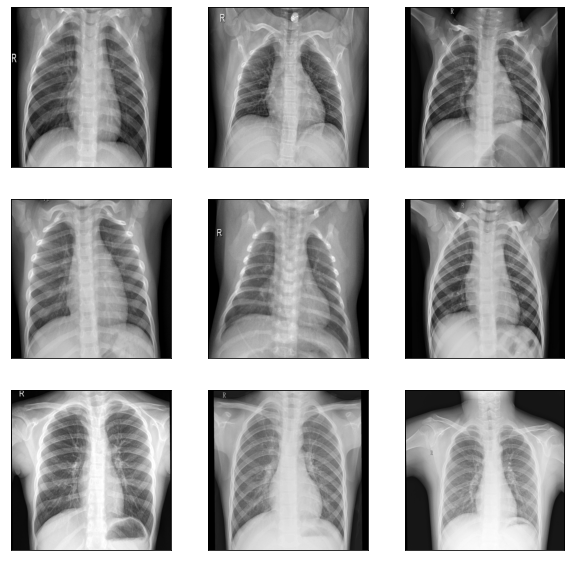

In [ ]:
show_images_grid(3, 3, 'gray', *test_normal[:9], figsize = (10, 10))

### Pneumonia virus imgs

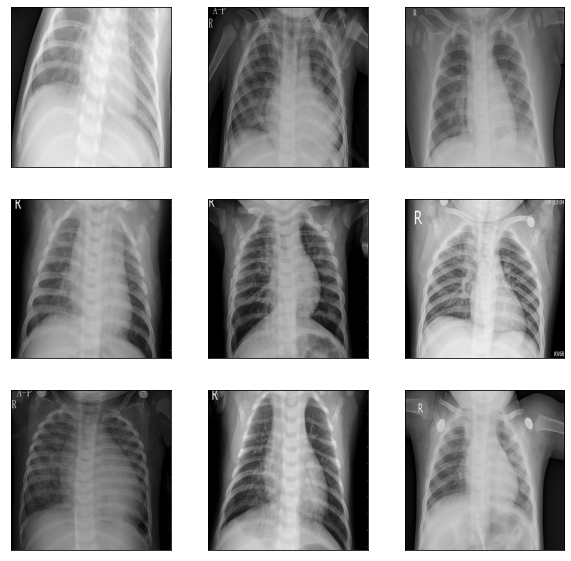

In [ ]:
show_images_grid(3, 3, 'gray', *train_pneumonia_virus[:9], figsize = (10, 10))

### Pneumonia bacteria

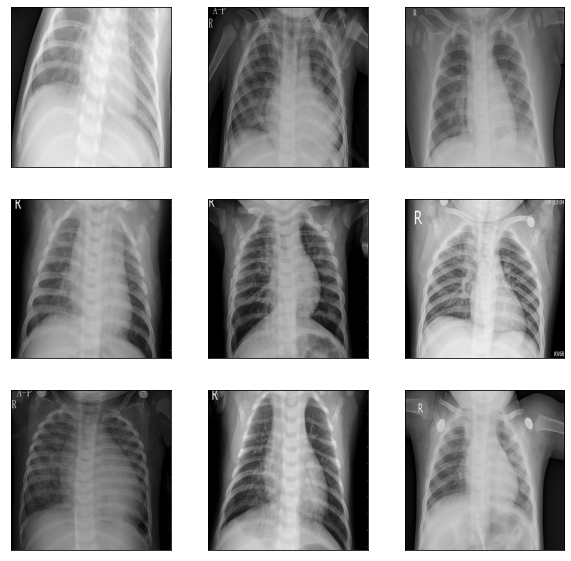

In [ ]:
show_images_grid(3, 3, 'gray', *train_pneumonia_virus[:9], figsize = (10, 10))

### Histogram of classe (normal, virus, bacteria) colors

Pedemos ver que existe uma pequena diferença na distribuição das imagens normais, com pneumonia tipo viral e do tipo bacteria. 

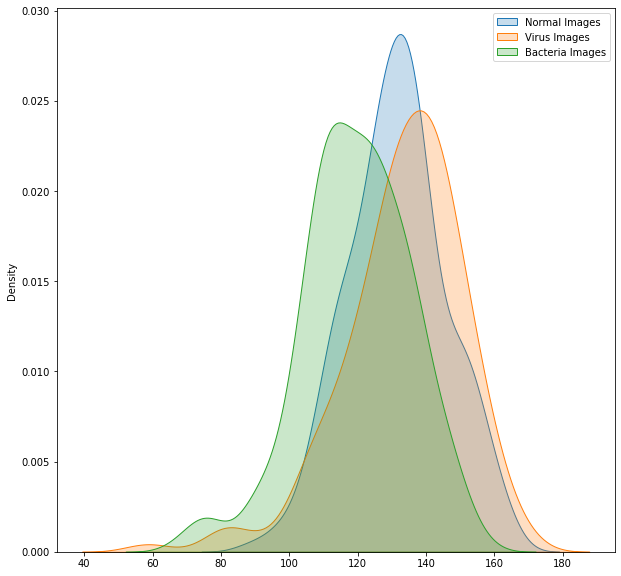

In [ ]:

def img_sum(img_array):
  img_array = img_array.ravel()
  img_array = img_array[img_array != 0]

  return img_array.mean()

sum_test_imgs_normal = np.array([img_sum(img) for img in test_normal])
sum_test_imgs_virus = np.array([img_sum(img) for img in test_pneumonia_virus])
sum_test_imgs_bacteria = np.array([img_sum(img) for img in test_pneumonia_bacteria])

plt.figure(figsize=(10, 10))
sns.kdeplot(sum_test_imgs_normal, shade=True, label = "Normal Images")
sns.kdeplot(sum_test_imgs_virus, shade=True, label = "Virus Images")
sns.kdeplot(sum_test_imgs_bacteria, shade=True, label = "Bacteria Images")
plt.legend()

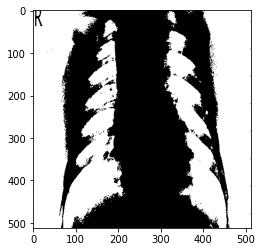

In [ ]:
# image binarization

from skimage.filters import threshold_otsu, threshold_local

#block_size = 35
#local_thresh = threshold_local(test_normal[1], block_size, offset=10)
#binary_local = test_normal[3] > local_thresh
img = test_normal[79] > 127.5
plt.imshow(img, cmap='binary')

# Create cnn models

## Create simple classifier cnn

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import *

##model building
def create_model(num_category, img_w=64, img_h=64, chanels=1):

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=(img_w, img_h, chanels)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_category, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])
  
  return model
  

## Create transfer learning classification model with InceptionV3

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3

def create_inception_model(num_category, img_width, img_height):
  pre_trained_inceptionv3 = InceptionV3(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
  pre_trained_inceptionv3.trainable = False

  x = layers.Flatten()(pre_trained_inceptionv3.output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(num_category, activation='softmax')(x)

  model = models.Model(pre_trained_inceptionv3.input, x)
  model.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
  
  return model

# Train cnn models

In [ ]:
results = []

In [ ]:
from keras.utils import np_utils
from rx import operators as op, of

def get_train_test(with_pneumonia_type = False, pre_processing=lambda a: a, balance_data=False):
  train_virus = train_pneumonia_virus
  train_bacteria = train_pneumonia_bacteria
  if balance_data:
    idx_pv = list(range(len(train_pneumonia_virus)))
    idx_pb = list(range(len(train_pneumonia_bacteria)))
    train_virus = train_pneumonia_virus[np.random.choice(idx_pv, 700)]
    train_bacteria = train_pneumonia_bacteria[np.random.choice(idx_pb, 700)]

  trainX = of(*np.concatenate([train_normal, train_virus, train_bacteria])) \
  .pipe(
      op.map(pre_processing),
      op.to_list(),
      op.map(lambda a: np.array(a))
  ).run()
  testX = of(*np.concatenate([test_normal, test_pneumonia_virus, test_pneumonia_bacteria])) \
  .pipe(
      op.map(pre_processing),
      op.to_list(),
      op.map(lambda a: np.array(a)) 
  ).run()

  if with_pneumonia_type:
    num_category = 3
    trainY = [0] * len(train_normal) + [1] * len(train_virus) + [2] * len(train_bacteria)
    testY = [0] * len(test_normal) + [1] * len(test_pneumonia_virus) + [2] * len(test_pneumonia_bacteria)
  else:
    num_category = 2
    trainY = [0] * len(train_normal) + [1] * (len(train_virus) + len(train_bacteria))
    testY = [0] * len(test_normal) + [1] * (len(test_pneumonia_virus) + len(test_pneumonia_bacteria))

  trainY = np_utils.to_categorical(trainY)
  testY = np_utils.to_categorical(testY)
  
  return trainX, trainY, testX, testY, num_category

In [ ]:
from rx import pipe
from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def evaluate_model(model, testX, testY):
  y_pred = [np.argmax(out) for out in model.predict(testX)]
  y_true = [np.argmax(out) for out in testY]
  accuracy = metrics.accuracy_score(y_true, y_pred)
  balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
  precision = metrics.precision_score(y_true, y_pred, average='weighted')
  recall = metrics.recall_score(y_true, y_pred, average='weighted')

  return {
      "accuracy": accuracy,
      "balanced_accuracy": balanced_accuracy,
      "precision": np.mean(precision),
      "recall": np.mean(recall),
  }

def train_model(with_pneumonia_type, pre_processing, balance_data=False, model=None, **kwargs):
  trainX, trainY, testX, testY, num_category = get_train_test(
      with_pneumonia_type = with_pneumonia_type,
      pre_processing=pre_processing,
      balance_data=balance_data
  )

  if model is None:
    model = create_model(num_category)

  trainX = (trainX/255).astype("float16")
  testX = (testX/255).astype("float16")
  model_log = model.fit(trainX, trainY,
          validation_data=(testX, testY),
           **kwargs)

  return model, model_log, evaluate_model(model, testX, testY)

def plot_results(history, accuracy_metrics):
  fig = plt.figure(figsize=(20, 5))
  ax = fig.add_subplot(132)
  ax1 = fig.add_subplot(131)
  ax2 = fig.add_subplot(133)
  ax.plot(history["loss"], label="train loss")
  ax.plot(history["val_loss"], label="val loss")
  ax1.plot(history["accuracy"], label="train accuracy")
  ax1.plot(history["val_accuracy"], label="val accuracy")
  ax2.bar(list(accuracy_metrics.keys()), list(accuracy_metrics.values()))
  ax.legend()
  ax1.legend()

pre_process_64x64 = pipe(
    Image.fromarray,
    lambda img: img.resize((64, 64), Image.LANCZOS),
    np.array,
    lambda img_array: np.expand_dims(img_array, axis=-1)
)

## Train models with basic cnn

In [ ]:
#### Model arquictecture

model = create_model(3, 64, 64, 1)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 58, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 107648)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               13779072  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

### Train model that predict pneumonia type (virus, bacteria)

CNN classifier: Simple <br>
Image pre-processing: resize to 64x64 and normalization <br>
Val Accuracy: 0.7

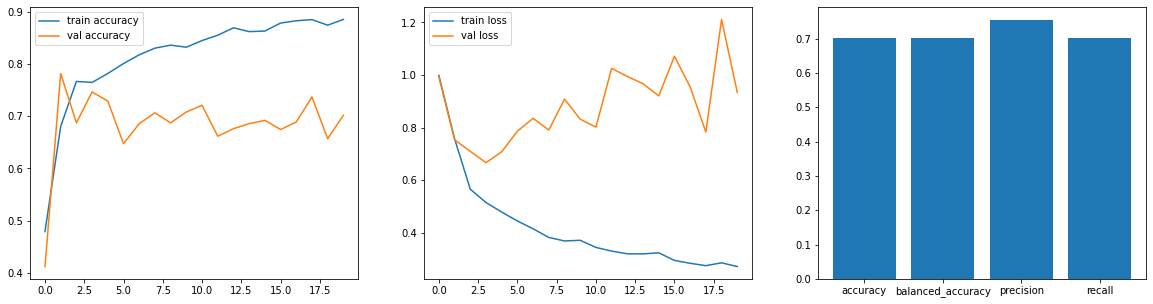

In [ ]:
batch_size = 128
num_epoch = 20

model, model_log, validation = train_model(True, pre_process_64x64, batch_size=batch_size,
                                           epochs=num_epoch, verbose=0, shuffle=True, 
                                           callbacks=[TqdmCallback(verbose=1)], balance_data=True)
results.append(["simple cnn", "64x64", True, None, *validation.values()])
plot_results(model_log.history, validation)

### Train model without predict pneumonia type (virus, bacteria) with base cnn
CNN classifier: Simple <br>
Image pre-processing: resize to 64x64 and normalization <br>
Val Accuracy: 0.79

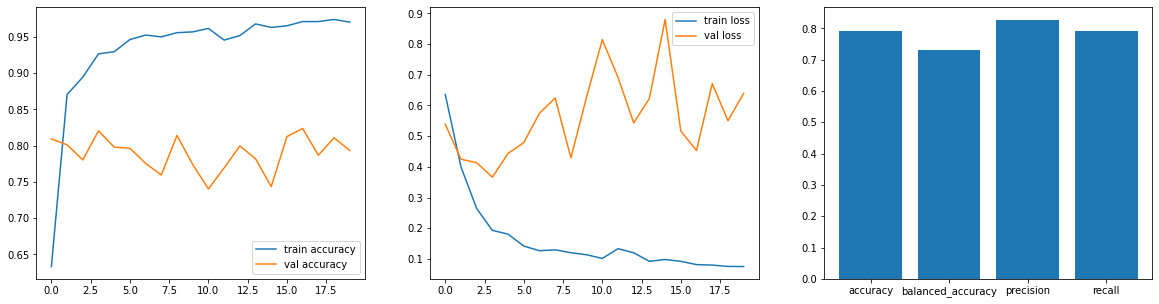

In [ ]:
batch_size = 128
num_epoch = 20

model, model_log, validation = train_model(False, pre_process_64x64, batch_size=batch_size,
                                           epochs=num_epoch, verbose=0, shuffle=True,
                                           callbacks=[TqdmCallback(verbose=1)], balance_data=True)
results.append(["simple cnn", "64x64", False, None, *validation.values()])
plot_results(model_log.history, validation)

### Train model without predict pneumonia type (virus, bacteria) with base cnn and 128x128 image

CNN classifier: Simple <br>
Image pre-processing: resize to 128x128 and normalization <br>
Val Accuracy: 0.78

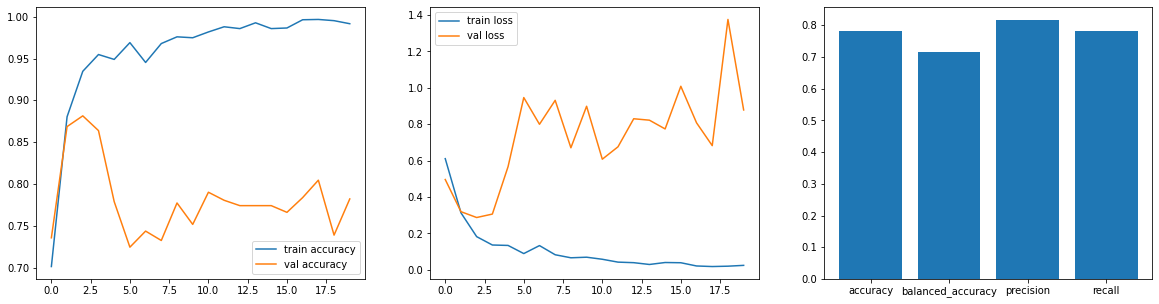

In [ ]:
batch_size = 128
num_epoch = 20

pre_process = pipe(
    Image.fromarray,
    lambda img: img.resize((128, 128), Image.LANCZOS),
    np.array,
    lambda img_array: np.expand_dims(img_array, axis=-1)
)

model = create_model(2, 128, 128, 1)
model, model_log, validation = train_model(False, pre_process, batch_size=batch_size,
                                           epochs=num_epoch, verbose=0, shuffle=True, model=model,
                                           callbacks=[TqdmCallback(verbose=1)], balance_data=True)
results.append(["simple cnn", "128x128", False, None, *validation.values()])
plot_results(model_log.history, validation)

### Train model without predict pneumonia type (virus, bacteria) with base cnn and 128x128 image with viridis color map

CNN classifier: Simple <br>
Image pre-processing: resize to 128x128, veridis cmap and normalization <br>
Val Accuracy: 0.77

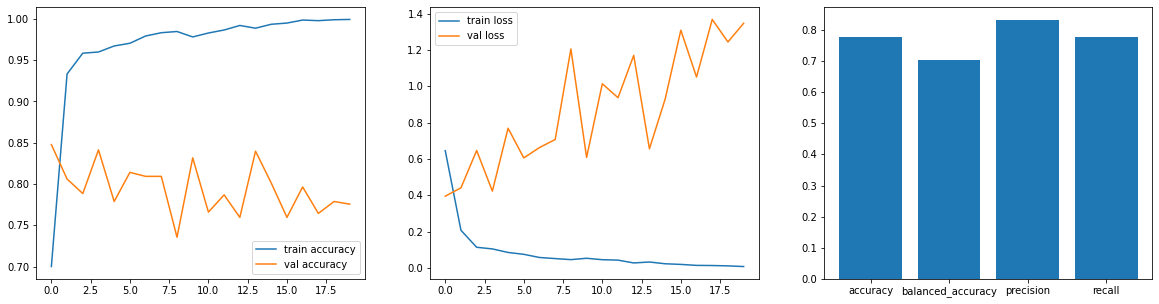

In [ ]:
batch_size = 128
num_epoch = 20

cmap = plt.get_cmap('viridis')

pre_process = pipe(
    cmap,
    lambda img_array: (img_array[:,:,:3] * 255).astype("uint8"),
    Image.fromarray,
    lambda img: img.resize((128, 128), Image.LANCZOS),
    np.array,
)

model = create_model(2, 128, 128, 3)
model, model_log, validation = train_model(False, pre_process, batch_size=batch_size,
                                           epochs=num_epoch, verbose=0, shuffle=True, model=model,
                                           callbacks=[TqdmCallback(verbose=1)], balance_data=True)
results.append(["simple cnn", "128x128", False, 'veridis cmap', *validation.values()])
plot_results(model_log.history, validation)

## Use transfer learning with Inception-v3 

In [ ]:
# convert image to rgb tr color map

cmap = plt.get_cmap('viridis')

rgb_pre_process = pipe(
    cmap,
    lambda img_array: (img_array[:,:,:3] * 255).astype("uint8"),
    Image.fromarray,
    lambda img: img.resize((128, 128), Image.LANCZOS),
    np.array,
)

### Train Inception-v3 128x128 images without predict pneumonia type (virus, bacteria) 

CNN classifier: Transfer Inception-v3<br>
Image pre-processing: resize to 128x128, veridis cmap and normalization <br>
Val Accuracy: 0.84

Epoch 1/20
22/22 [==============================] - 4s 195ms/step - loss: 0.9240 - accuracy: 0.8004 - val_loss: 1.1307 - val_accuracy: 0.7532
Epoch 2/20
22/22 [==============================] - 2s 98ms/step - loss: 0.2790 - accuracy: 0.9117 - val_loss: 0.4677 - val_accuracy: 0.8654
Epoch 3/20
22/22 [==============================] - 2s 98ms/step - loss: 0.1741 - accuracy: 0.9391 - val_loss: 0.4958 - val_accuracy: 0.8478
Epoch 4/20
22/22 [==============================] - 2s 99ms/step - loss: 0.1348 - accuracy: 0.9482 - val_loss: 0.4963 - val_accuracy: 0.8413
Epoch 5/20
22/22 [==============================] - 2s 99ms/step - loss: 0.1007 - accuracy: 0.9613 - val_loss: 0.6284 - val_accuracy: 0.8221
Epoch 6/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0908 - accuracy: 0.9650 - val_loss: 0.6195 - val_accuracy: 0.8301
Epoch 7/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0733 - accuracy: 0.9704 - val_loss: 0.6403 - val_accuracy: 0.8237
Epoch 8/20
2

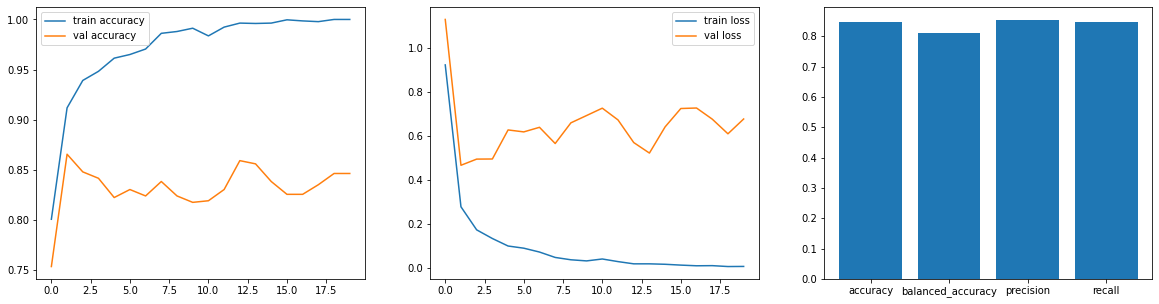

In [ ]:
batch_size = 128
num_epoch = 20
model = create_inception_model(2, 128, 128)
model, model_log, validation = train_model(False, rgb_pre_process, batch_size=batch_size,
                                           epochs=num_epoch, verbose=1, shuffle=True,
                                           model=model, balance_data=True)
results.append(["Inception-v3", "128x128", False, 'veridis cmap', *validation.values()])
plot_results(model_log.history, validation)

### Train Inception-v3 128x128 images predict pneumonia type (virus, bacteria)

CNN classifier: Transfer Inception-v3<br>
Image pre-processing: resize to 128x128, veridis cmap and normalization <br>
Val Accuracy: 0.72

Epoch 1/20
22/22 [==============================] - 3s 151ms/step - loss: 2.0055 - accuracy: 0.6082 - val_loss: 1.1425 - val_accuracy: 0.5801
Epoch 2/20
22/22 [==============================] - 2s 98ms/step - loss: 0.6171 - accuracy: 0.7742 - val_loss: 0.7359 - val_accuracy: 0.7324
Epoch 3/20
22/22 [==============================] - 2s 99ms/step - loss: 0.4475 - accuracy: 0.8161 - val_loss: 0.7026 - val_accuracy: 0.7436
Epoch 4/20
22/22 [==============================] - 2s 100ms/step - loss: 0.3774 - accuracy: 0.8420 - val_loss: 0.9022 - val_accuracy: 0.6298
Epoch 5/20
22/22 [==============================] - 2s 99ms/step - loss: 0.2961 - accuracy: 0.8836 - val_loss: 0.6688 - val_accuracy: 0.7276
Epoch 6/20
22/22 [==============================] - 2s 99ms/step - loss: 0.2961 - accuracy: 0.8800 - val_loss: 0.6836 - val_accuracy: 0.7564
Epoch 7/20
22/22 [==============================] - 2s 101ms/step - loss: 0.2171 - accuracy: 0.9227 - val_loss: 0.6470 - val_accuracy: 0.7756
Epoch 8/20

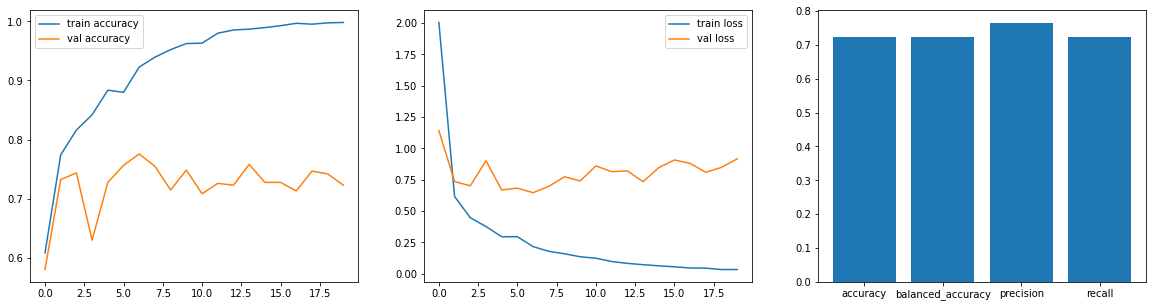

In [ ]:
batch_size = 128
num_epoch = 20
model = create_inception_model(3, 128, 128)
model, model_log, validation = train_model(True, rgb_pre_process, batch_size=batch_size,
                                           epochs=num_epoch, verbose=1, shuffle=True, 
                                           model=model, balance_data=True)
results.append(["Inception-v3", "128x128", True, 'veridis cmap', *validation.values()])
plot_results(model_log.history, validation)

# Avaliação dos resultados

A previsão foi dividida em dois tipo no treinamento, a previsão se o paciente em pneumonia e a previsão do tipo de pneumonia que ele tem, em ambos os caso o modelo Inception-v3 ganhou se apenas a acurácia for considerada, já que esse modelo obteve 84% de acurácia na predição de pneumonia e 72% na previsão do tipo de pneumonia (virus, bacteria). Em se tratando da precisão e do recall os resultados também foram semelhantes com o modelo Inception-v3 vencendo. Com isso podemos concluir que o molelo Inception-v3 treinado atravez de transfer learning foi superior.

In [ ]:
import pandas as pd
df_results = pd.DataFrame(data=results, columns=["cnn type", "img_size", "Pred.pnomonia.type", "color map",
                                                 "accuracy", "balanced_accuracy", "precision", "recall"])
df_results

,cnn type,img_size,Pred.pnomonia.type,color map,accuracy,balanced_accuracy,precision,recall
0,simple cnn,64x64,True,None,0.701923,0.702235,0.754680,0.701923
1,simple cnn,64x64,False,None,0.793269,0.730342,0.826951,0.793269
2,simple cnn,128x128,False,None,0.782051,0.716239,0.816821,0.782051
3,simple cnn,128x128,False,veridis cmap,0.775641,0.701709,0.831558,0.775641
4,Inception-v3,128x128,False,veridis cmap,0.846154,0.809402,0.853699,0.846154
5,Inception-v3,128x128,True,veridis cmap,0.722756,0.723163,0.764257,0.722756


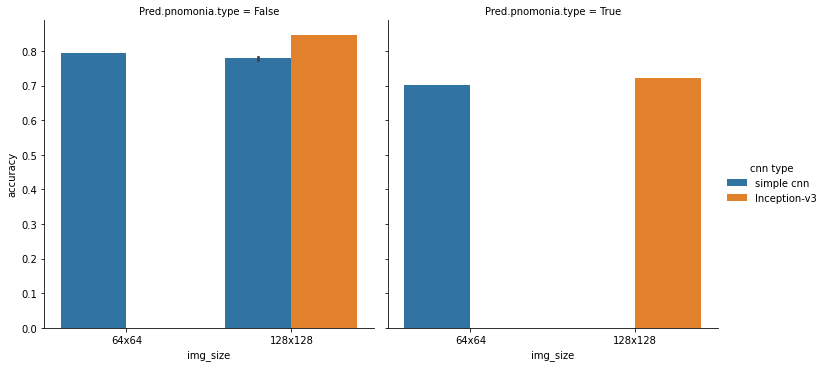

In [ ]:
# plot da acuracia dos modelos

sns.catplot(data=df_results, x="img_size", y="accuracy", hue="cnn type", col="Pred.pnomonia.type", kind="bar", sharex=False)

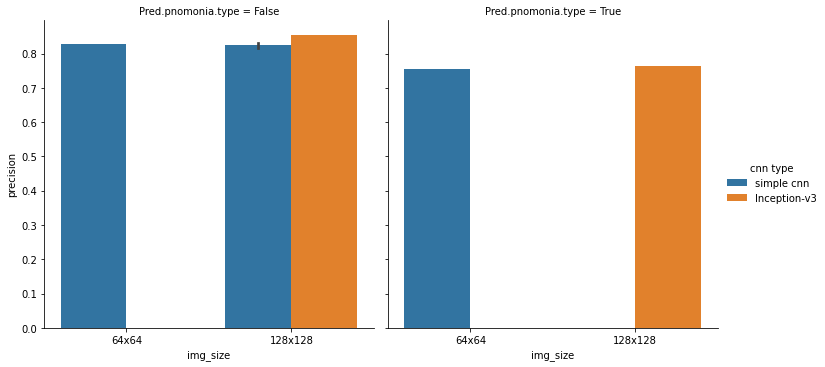

In [ ]:
# plot da precisão dos modelos

sns.catplot(data=df_results, x="img_size", y="precision", hue="cnn type", col="Pred.pnomonia.type", kind="bar", sharex=False)

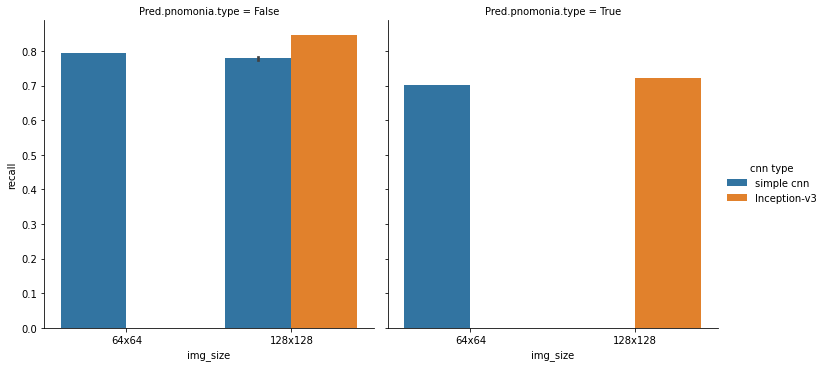

In [ ]:
# plot do recall dos modelos

sns.catplot(data=df_results, x="img_size", y="recall", hue="cnn type", col="Pred.pnomonia.type", kind="bar", sharex=False)